In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Append custom library path (if you have a library to include)
import sys
custom_library_path = '/content/drive/MyDrive/your_custom_library'  # Update if you have any custom library
sys.path.append(custom_library_path)

# Activate GPU for training
!nvidia-smi

Mounted at /content/drive
Tue Nov 12 14:17:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------

In [ ]:
# Step 1: Import necessary libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb # current XGboost ver 2.1.2
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm  # Added for progress indicators
import logging
import warnings
from torch.cuda.amp import autocast

# Set up logging to capture warnings
logging.basicConfig(filename='warnings.log', level=logging.WARNING)
logging.captureWarnings(True)

In [ ]:
# Step 2: Paths for images and masks
covid_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/COVID19_xrays"
noncovid_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/NonCOVID19_xrays"
normal_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/Normal_xrays"

covid_mask_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/lung_masks_COVID19"
noncovid_mask_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/lung_masks_NonCOVID"
normal_mask_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/lung_masks_Normal"


In [ ]:
import os
os.cpu_count() # adjust the num_workers below

2

In [ ]:
# Step 3: Parameters
num_images = 1000  # Adjust sample size as needed
image_size = 224  # Adjusted for ResNet50
batch_size = 68  # Adjusted batch size
num_workers = 2  # 4 for T4, 9 for L4, 2 or 8 for normal CPU -time dependent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load image and mask file paths
def load_image_mask_paths(image_path, mask_path, num_images):
    image_files = os.listdir(image_path)[:num_images]
    image_paths = [os.path.join(image_path, img) for img in image_files]
    mask_paths = [os.path.join(mask_path, img) for img in image_files]
    return image_paths, mask_paths


In [ ]:
# Step 5: Load data paths
covid_image_paths, covid_mask_paths = load_image_mask_paths(covid_path, covid_mask_path, num_images)
noncovid_image_paths, noncovid_mask_paths = load_image_mask_paths(noncovid_path, noncovid_mask_path, num_images)
normal_image_paths, normal_mask_paths = load_image_mask_paths(normal_path, normal_mask_path, num_images)

# Create labels
covid_labels = np.zeros(len(covid_image_paths))
noncovid_labels = np.ones(len(noncovid_image_paths))
normal_labels = np.full(len(normal_image_paths), 2)

# Combine data
image_paths = covid_image_paths + noncovid_image_paths + normal_image_paths
mask_paths = covid_mask_paths + noncovid_mask_paths + normal_mask_paths
labels = np.concatenate((covid_labels, noncovid_labels, normal_labels), axis=0)


In [ ]:
# Step 6: Split data into train, validation, and test sets
train_image_paths, test_image_paths, train_labels, test_labels, train_mask_paths, test_mask_paths = train_test_split(
    image_paths, labels, mask_paths, test_size=0.3, random_state=42, stratify=labels)
val_image_paths, test_image_paths, val_labels, test_labels, val_mask_paths, test_mask_paths = train_test_split(
    test_image_paths, test_labels, test_mask_paths, test_size=0.5, random_state=42, stratify=test_labels)


In [ ]:
# Step 7: Define custom Dataset class
class XRayDataset(Dataset):
    def __init__(self, image_paths, mask_paths, labels, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask on-the-fly
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            warnings.warn(f"Error loading image or mask at index {idx}")
            # You can handle the error here, e.g., skip this sample or return a default value
            return None

        image = cv2.resize(image, (image_size, image_size)) / 255.0
        mask = cv2.resize(mask, (image_size, image_size)) / 255.0

        # Apply mask to the image
        image = image * mask
        image = np.stack([image, image, image], axis=-1)  # Convert to 3 channels for ResNet50

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Step 8: Define transformations
# Adjusted normalization for ResNet50
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])    # ImageNet std
])

val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])    # ImageNet std
])


In [ ]:
# Step 9: Create datasets and data loaders
train_dataset = XRayDataset(train_image_paths, train_mask_paths, train_labels, transform=train_transform)
val_dataset = XRayDataset(val_image_paths, val_mask_paths, val_labels, transform=val_test_transform)
test_dataset = XRayDataset(test_image_paths, test_mask_paths, test_labels, transform=val_test_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=2,  # Default is 2, can be increased
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=2
)


In [ ]:
# Step 10: Load pre-trained ResNet50 model as feature extractor
resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
feature_extractor = nn.Sequential(*list(resnet50.children())[:-1])  # Remove the last FC layer
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

# Function to extract features with progress indicator
def extract_features(data_loader, model, device, description):
    features = []
    labels = []
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc=description):
            # Move images and targets to the appropriate device
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            # Use mixed precision with autocast for the forward pass
            with autocast():
                outputs = model(images)  # Forward pass with mixed precision

            # Flatten the outputs
            outputs = outputs.view(outputs.size(0), -1)

            # Collect features and labels
            features.append(outputs.cpu().numpy())
            labels.extend(targets.cpu().numpy())

    # Concatenate all features and labels into single arrays
    features = np.concatenate(features, axis=0)
    labels = np.array(labels)
    return features, labels

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 143MB/s]


In [ ]:
# Step 11: Extract features for train, validation, and test sets with progress bars
print("Extracting train features...")
train_features, train_labels = extract_features(train_loader, feature_extractor, device, description="Train Feature Extraction")

print("Extracting validation features...")
val_features, val_labels = extract_features(val_loader, feature_extractor, device, description="Validation Feature Extraction")

print("Extracting test features...")
test_features, test_labels = extract_features(test_loader, feature_extractor, device, description="Test Feature Extraction")


Extracting train features...


Train Feature Extraction: 100%|██████████| 31/31 [12:48<00:00, 24.80s/it]


Extracting validation features...


Validation Feature Extraction: 100%|██████████| 7/7 [02:52<00:00, 24.69s/it]


Extracting test features...


Test Feature Extraction: 100%|██████████| 7/7 [02:57<00:00, 25.29s/it]


In [ ]:
# Step 12: Encode labels (if necessary)
# Ensure labels are integers starting from 0
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)


In [ ]:
# Step 13: Define and train the XGBoost classifier with updated parameters
xgb_classifier = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=3,
    random_state=42,
    tree_method='hist',  # Updated to use GPU
    predictor='gpu_predictor'  # Ensure the model uses GPU for predictions
)

print("Training XGBoost classifier...")
xgb_classifier.fit(
    train_features, train_labels_encoded,
    eval_set=[(val_features, val_labels_encoded)],
    verbose=True
)


Training XGBoost classifier...


Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)



[0]	validation_0-mlogloss:1.09209
[1]	validation_0-mlogloss:1.08596
[2]	validation_0-mlogloss:1.07956
[3]	validation_0-mlogloss:1.07351
[4]	validation_0-mlogloss:1.06714
[5]	validation_0-mlogloss:1.06111
[6]	validation_0-mlogloss:1.05479
[7]	validation_0-mlogloss:1.04844
[8]	validation_0-mlogloss:1.04271
[9]	validation_0-mlogloss:1.03664
[10]	validation_0-mlogloss:1.03063
[11]	validation_0-mlogloss:1.02473
[12]	validation_0-mlogloss:1.01975
[13]	validation_0-mlogloss:1.01432
[14]	validation_0-mlogloss:1.00875
[15]	validation_0-mlogloss:1.00305
[16]	validation_0-mlogloss:0.99745
[17]	validation_0-mlogloss:0.99265
[18]	validation_0-mlogloss:0.98759
[19]	validation_0-mlogloss:0.98280
[20]	validation_0-mlogloss:0.97815
[21]	validation_0-mlogloss:0.97305
[22]	validation_0-mlogloss:0.96821
[23]	validation_0-mlogloss:0.96378
[24]	validation_0-mlogloss:0.95912
[25]	validation_0-mlogloss:0.95455
[26]	validation_0-mlogloss:0.95015
[27]	validation_0-mlogloss:0.94538
[28]	validation_0-mlogloss:0.9

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [ ]:
# Step 14: Evaluate on test set
test_preds = xgb_classifier.predict(test_features)
test_accuracy = accuracy_score(test_labels_encoded, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Classification Report:")
print(classification_report(test_labels_encoded, test_preds, target_names=['COVID', 'Non-COVID', 'Normal']))

# Plot feature importance
xgb.plot_importance(xgb_classifier, max_num_features=20)
plt.show()

Test Accuracy: 0.8022
Classification Report:
              precision    recall  f1-score   support

       COVID       0.81      0.85      0.83       150
   Non-COVID       0.94      0.73      0.82       150
      Normal       0.71      0.82      0.76       150

    accuracy                           0.80       450
   macro avg       0.82      0.80      0.80       450
weighted avg       0.82      0.80      0.80       450



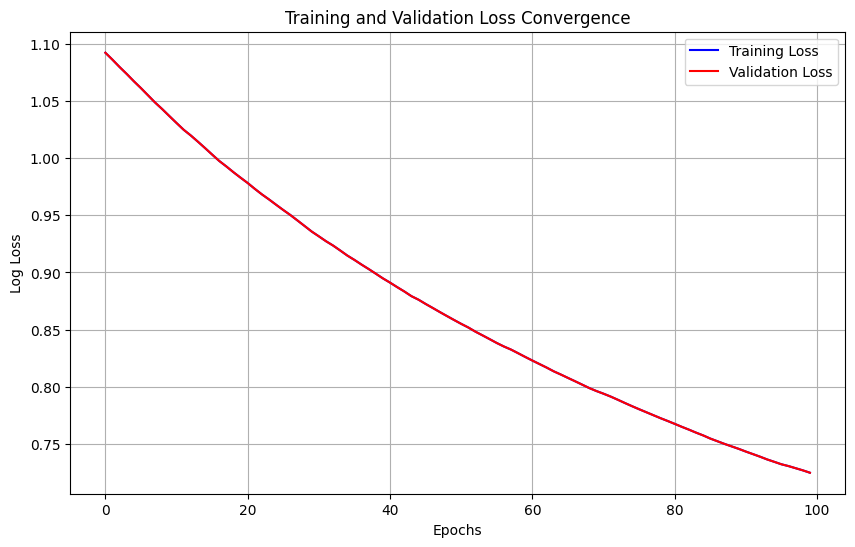

In [ ]:
# Step 15: Plot Training and Validation Loss Convergence

# Extract training and validation metrics from the XGBoost model
results = xgb_classifier.evals_result()

# Extract the log loss values for training and validation
train_loss = results['validation_0']['mlogloss']
val_loss = results['validation_0']['mlogloss'] if len(results) < 2 else results['validation_1']['mlogloss']

# Plotting the training and validation loss convergence
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='b')
plt.plot(val_loss, label='Validation Loss', color='r')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training and Validation Loss Convergence')
plt.legend()
plt.grid()
plt.show()

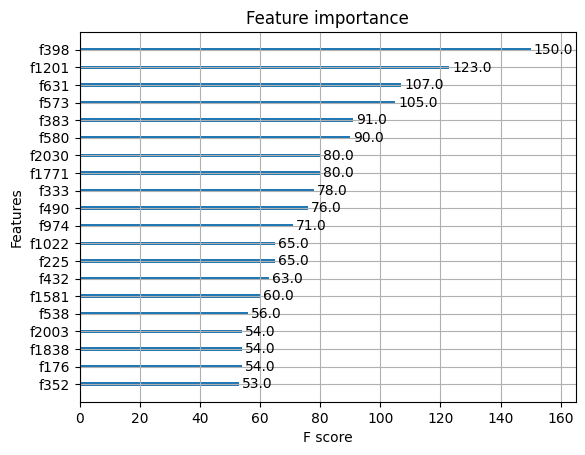

In [ ]:
# Step 15: Save the XGBoost model
#model_save_path = '/content/drive/MyDrive/final_XGBoost_model.json'
#xgb_classifier.save_model(model_save_path)
#print(f'Model saved to {model_save_path}')

# Plot feature importance
xgb.plot_importance(xgb_classifier, max_num_features=20)
plt.show()